<a href="https://colab.research.google.com/github/Minh-A/Pytorch_DeepLearning/blob/main/CNN_CRNN_210218.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

라이브러리

In [ ]:
# 파이토치 라이브러리 임포트
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader, TensorDataset
from torch.autograd import Variable  # 자동미분기능 제공
import torch.optim as optim

np.random.seed(777)
torch.manual_seed(777)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # GPU, CPU 선택
print('CPU? GPU? : ', device)

CPU? GPU? :  cuda:0


In [ ]:
# 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CNN 

데이터 불러오기

In [ ]:
# 온도 데이터 불러오기
tem = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pytorch 책/file/time_series/ta_20210108214059.csv', skiprows=[0,1,2,3,4,5], encoding="cp949")

# 결측치 평균값으로 통일
tem.loc[tem.isna().iloc[:,4] == True, '최고기온(℃)'] = round(((tem.iloc[1014,4] + tem.iloc[1016,4]) / 2),2)  

tem

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
0,2015-01-01,108,-7.7,-9.8,-4.3
1,2015-01-02,108,-6.0,-9.0,-1.9
2,2015-01-03,108,-2.7,-9.2,3.1
3,2015-01-04,108,2.5,0.2,8.5
4,2015-01-05,108,3.7,-1.1,7.9
...,...,...,...,...,...
2187,2020-12-27,108,5.8,1.4,10.0
2188,2020-12-28,108,6.7,4.2,11.4
2189,2020-12-29,108,0.1,-6.2,4.3
2190,2020-12-30,108,-10.9,-12.9,-6.2


In [ ]:
# 훈련, 테스트 만들기
train = tem.iloc[:-365,2:]
test = tem.iloc[-365:,2:]

데이터 전처리
> CNN 데이터 사이즈
* 합성곱 층: 전체 데이터 사이즈 - 필터 사이즈 +1
* 합성곱의 마지막층에는 +1이 필요없음 => 그냥 나오니까
* 풀링 층: 2로 설정하면 나누기 2
* 반올림은 없고 내림만 있음

> 필터 수에 따른 데이터 사이즈 정리
* 필터 수가
* 홀수라면 +1때문에 짝수로 됨
* 짝수라면 홀수가 되며, 전체 데이터 셋에서 +3을 해주어야 함

In [ ]:
# 배치 사이즈
input_window = 1457       # 모델에 들어가는 날짜, 슬라이딩 윈도우의 간격
output_window = 365       # 모델을 통해 예측한 날짜

# 행렬을 먼저 만듬
window_x = np.zeros((train.shape[0] - (input_window + output_window), input_window, 3))  # 전체 데이터, 들어갈 데이터, 컬럼수
window_y = np.zeros((train.shape[0] - (input_window + output_window), output_window, 3))

# 슬라이딩 윈도우 생성
for start in range(train.shape[0] - (input_window + output_window)):
    end = start + input_window 

    window_x[start,:, :] = train.iloc[start : end , : ].values   # X 데이터셋 만들기
    window_y[start,:, :] = train.iloc[end   : end + output_window, : ].values   # 예측할 Y 데이터셋 (훈련시)

# 훈련 데이터 텐서 변환
train_x = torch.from_numpy(window_x).float().to(device)
train_y = torch.from_numpy(window_y).float().to(device)

In [ ]:
train_x.shape   # 전체 데이터의 길이, 배치 사이즈, 인풋 사이즈 (seq_len x batch_size x input_size)

torch.Size([5, 1457, 3])

In [ ]:
train_y.shape

torch.Size([5, 365, 3])

## CNN 모델

In [ ]:
# CNN Model

class CNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.c1 = nn.Conv1d(input_size, hidden_size, 365)
        # self.p1 = nn.AvgPool1d(2)

        self.c2 = nn.Conv1d(hidden_size, hidden_size, 365)
        # self.p2 = nn.AvgPool1d(2)

        self.c3 = nn.Conv1d(hidden_size, hidden_size, 365)

        self.out = nn.Linear(hidden_size, 3)


    def forward(self, inputs):

        # Turn (seq_len x batch_size x input_size) into (batch_size x input_size x seq_len) for CNN
        inputs = inputs.transpose(1, 2)  # "3행 730열"로 732개의 데이터를 생성

        c = self.c1(inputs)
        # c = self.p1(c)
        c = self.c2(c)
        # c = self.p2(c)

        p = self.c3(c)
        p = p.transpose(2, 1)        

        p = self.out(p[:,-365:, :])
        return p.view(-1,365,3)


model_cnn = CNN(input_size = 3, hidden_size = 64).to(device)  # to(device)를 통해 GPU로
model_cnn

CNN(
  (c1): Conv1d(3, 64, kernel_size=(365,), stride=(1,))
  (c2): Conv1d(64, 64, kernel_size=(365,), stride=(1,))
  (c3): Conv1d(64, 64, kernel_size=(365,), stride=(1,))
  (out): Linear(in_features=64, out_features=3, bias=True)
)

In [ ]:
# 모형 학습

# 최적화 담당
optimizer = optim.Adam(model_cnn.parameters(), lr = 0.0001)  # Adam 경사하강법을 사용
# Learning Rate는 큰 사이즈일 경우 매우 작게 조정?!

criterion = nn.MSELoss()

for epoch in range(2000):
  total_loss = 0
  optimizer.zero_grad()  # 경사초기화
  output = model_cnn(train_x)  # 순전파 계산
  loss = criterion(output, train_y)  # 오차 계산

  
  loss.backward()  # 역전파 계산
  optimizer.step()  #가중치 업데이트

  total_loss += loss.data  # 누적오차 계산
  
  # 50회 반복마다 누적 오차 계산
  if (epoch+1) % 100 == 0:
    print(epoch+1, float(total_loss))


100 7.434145450592041
200 5.603446006774902
300 4.1416778564453125
400 2.975938558578491
500 2.0890052318573
600 1.7882513999938965
700 1.1765937805175781
800 0.949294924736023
900 0.7787045240402222
1000 0.6409567594528198
1100 0.5272826552391052
1200 0.4332432746887207
1300 0.35548290610313416
1400 0.29106613993644714
1500 0.23748797178268433
1600 0.19276738166809082
1700 0.1554287225008011
1800 0.12487258017063141
1900 0.4151085913181305
2000 0.07841586321592331


In [ ]:
# 모델 예측

last_month = train.values[np.newaxis,...]  # 데이터 365일만
last_month = torch.tensor(last_month).float().to(device)  # 데이터를 토치화를 하여, GPU로 보냄

cnn_pre = []  # 저장하오

for start in range(1):  # 30일씩 3번 예측
    
    next_week = model_cnn(last_month)  # 365일 데이터로 5일을 예측

    last_month = torch.cat([last_month, next_week], axis = 1)  # 훈련데이터에 예측값을 더해 또 예측

    pred_week = next_week.detach().cpu().numpy().reshape(output_window,3)  # 예측한것 CPU, 넘파이로 (30,3)로 재배열

    cnn_pre.append(pred_week)  # 예측한거 저장하오


# 형식 변환 후, 데이터 프레임으로
cnn_pre = np.array(cnn_pre).reshape(365,3)
cnn_pre = pd.DataFrame(cnn_pre)
cnn_pre = round(cnn_pre,1)

print('365일 예측!! \n')
cnn_pre

365일 예측!! 



,0,1,2
0,-2.7,-7.4,1.2
1,-3.7,-7.3,0.5
2,-3.6,-7.5,1.7
3,-1.8,-4.3,1.8
4,-1.8,-3.7,0.9
...,...,...,...
360,-0.0,-4.0,4.5
361,-0.9,-5.3,4.0
362,-1.9,-6.9,3.5
363,-2.3,-6.7,2.1


예측 그래프

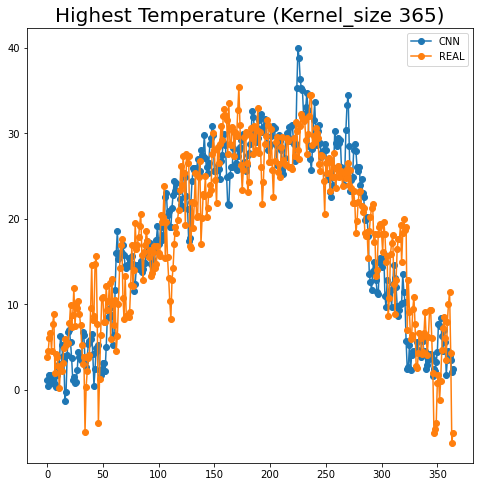

In [ ]:
# 365일 커널임
import matplotlib.pyplot as plt

pre = cnn_pre.loc[:,2]
real = test.iloc[:,2].reset_index(drop = True)

fig = plt.figure(figsize=(8,8))  ## 캔버스 생성
fig.set_facecolor('white')       ## 캔버스 색상 설정
ax = fig.add_subplot()           ## 그림 뼈대(프레임) 생성

# 그래프 생성
ax.plot(pre, marker='o',label='CNN')

ax.plot(real, marker='o',label='REAL') 

ax.legend() ## 범례
 
plt.title('Highest Temperature (Kernel_size 365)',fontsize=20) ## 타이틀 설정
plt.show()

커널 비교 그래프

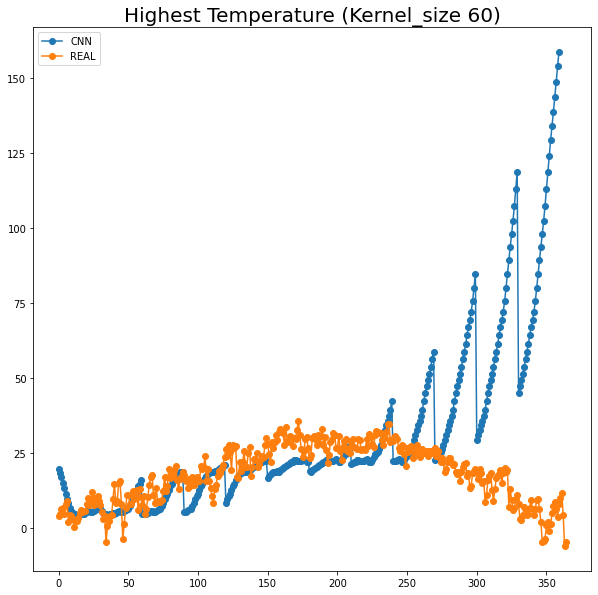

In [ ]:
# 60일 커널임
import matplotlib.pyplot as plt

pre = cnn_pre.loc[:,2]
real = test.iloc[:,2].reset_index(drop = True)

fig = plt.figure(figsize=(10,10))  ## 캔버스 생성
fig.set_facecolor('white')       ## 캔버스 색상 설정
ax = fig.add_subplot()           ## 그림 뼈대(프레임) 생성

# 그래프 생성
ax.plot(pre, marker='o',label='CNN')

ax.plot(real, marker='o',label='REAL') 

ax.legend() ## 범례
 
plt.title('Highest Temperature (Kernel_size 60)',fontsize=20) ## 타이틀 설정
plt.show()

3D 그래프

In [ ]:
# 데이터 전처리
real1 = test.copy().reset_index(drop = True)
pre1 = cnn_pre.copy().reset_index(drop = True)
pre1.columns = ['최고기온(℃)',	'최저기온(℃)',	'평균기온(℃)']

# 실제는 0, 예측은 1
real1['3'] = 'real'
pre1['3'] = 'pre'

# 데이터 합치기
data_3d = real1.append(pre1).reset_index(drop = True)
data_3d

,평균기온(℃),최저기온(℃),최고기온(℃),3
0,1.0,-0.7,3.8,real
1,-0.1,-3.4,4.6,real
2,1.2,-2.8,6.1,real
3,1.3,-3.2,6.6,real
4,3.1,0.6,4.6,real
...,...,...,...,...
725,4.5,-4.0,-0.0,pre
726,4.0,-5.3,-0.9,pre
727,3.5,-6.9,-1.9,pre
728,2.1,-6.7,-2.3,pre


In [ ]:
# 3D 그래프 확인
import plotly.express as px

print('\n 3D 그래프')

fig = px.scatter_3d(
    data_3d.iloc[:,0:3], x= '평균기온(℃)', y= '최저기온(℃)', z= '최고기온(℃)',
    title='Real VS CNN Pre',
    color= data_3d['3'],
    labels={"평균기온(℃)": 'Avg', "최저기온(℃)": 'Min', "최고기온(℃)": 'Max'}
)

fig.update_traces(marker=dict(size=5, line=dict(width=10,color='Black')), selector=dict(mode='markers'))  # 점 사이즈 결정

fig.update_layout(margin=dict(l=30, r=30, t=30, b=30))  # 그래프 사이즈 결정

fig.show()


 3D 그래프


# CRNN

In [ ]:
# 코로나 데이터 불러오기
cov = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pytorch 책/file/covid/covid_19_data.csv')
cov

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
172475,172476,12/06/2020,Zaporizhia Oblast,Ukraine,2020-12-07 05:26:14,36539.0,337.0,6556.0
172476,172477,12/06/2020,Zeeland,Netherlands,2020-12-07 05:26:14,6710.0,104.0,0.0
172477,172478,12/06/2020,Zhejiang,Mainland China,2020-12-07 05:26:14,1295.0,1.0,1288.0
172478,172479,12/06/2020,Zhytomyr Oblast,Ukraine,2020-12-07 05:26:14,31967.0,531.0,22263.0


Confirmed는 확진자수, Deaths는 사망자수, 그리고 Recovered는 완치자수를 의미

In [ ]:
# 데이터 전처리
conf = cov[cov['Country/Region']=='South Korea'].iloc[:,5].reset_index(drop = True)
conf = pd.DataFrame(conf)

# 훈련, 테스트 만들기
train = conf[50:-50]
test = conf[-50:]

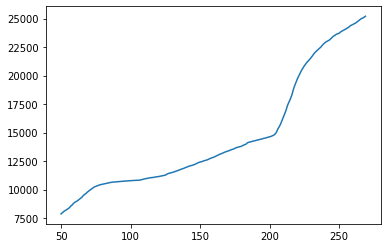

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train)

윈도우 생성

In [ ]:
# 배치 사이즈
input_window = 30       # 모델에 들어가는 날짜, 슬라이딩 윈도우의 간격
output_window = 5       # 모델을 통해 예측한 날짜

# 행렬을 먼저 만듬
window_x = np.zeros((train.shape[0] - (input_window + output_window), input_window, 1))  # 전체 데이터, 들어갈 데이터, 컬럼수
window_y = np.zeros((train.shape[0] - (input_window + output_window), output_window, 1))

# 슬라이딩 윈도우 생성
for start in range(train.shape[0] - (input_window + output_window)):
    end = start + input_window 

    window_x[start,:, :] = train.iloc[start : end , : ].values   # X 데이터셋 만들기
    window_y[start,:, :] = train.iloc[end   : end + output_window, : ].values   # 예측할 Y 데이터셋 (훈련시)

# 훈련 데이터 텐서 변환
train_x = torch.from_numpy(window_x).float().to(device)
train_y = torch.from_numpy(window_y).float().to(device)

print(train_x.shape, train_y.shape)

torch.Size([185, 30, 1]) torch.Size([185, 5, 1])


## CLSTM 모델

In [ ]:
model_clstm(train_x).shape

torch.Size([185, 29, 3])

In [ ]:
# Model 생성

class CLSTM(nn.Module):
    def __init__(self, hidden_size):
        super(CLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.c1 = nn.Conv1d(1, 3, 2)  # 커널 사이즈는 2
        # self.p1 = nn.AvgPool1d(2)
        # self.c2 = nn.Conv1d(hidden_size, hidden_size, 2)
  

        self.lstm = nn.LSTM(3, hidden_size, batch_first=True,
                            num_layers = 2)
        
        self.out = nn.Linear(hidden_size, 1)


    def forward(self, inputs):

        # Turn (seq_len x batch_size x input_size) into (batch_size x input_size x seq_len) for CNN
        inputs = inputs.transpose(1, 2)

        # Run through Conv1d and Pool1d layers
        p = self.c1(inputs)
        # c = self.p1(c)
        # p = self.c2(c)

        # Turn (batch_size x hidden_size x seq_len) back into (seq_len x batch_size x hidden_size) for RNN
        p = p.transpose(2, 1)

        time, _ = self.lstm(p)
        time = self.out(time[:,-5:, :])

        return time.view(-1,5,1)
        # return p


model_clstm = CLSTM(hidden_size = 32).to(device)  # to(device)를 통해 GPU로
model_clstm

CLSTM(
  (c1): Conv1d(1, 3, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(3, 32, num_layers=2, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
# 모형 학습

# 최적화 담당
optimizer = optim.Adam(model_clstm.parameters(), lr = 0.1)  # Adam 경사하강법을 사용
criterion = nn.MSELoss()

for epoch in range(2000):
  total_loss = 0
  optimizer.zero_grad()  # 경사초기화
  output = model_clstm(train_x)  # 순전파 계산
  loss = criterion(output, train_y)  # 오차 계산
  
  loss.backward()  # 역전파 계산
  optimizer.step()  #가중치 업데이트

  total_loss += loss.data  # 누적오차 계산
  
  # 50회 반복마다 누적 오차 계산
  if (epoch+1) % 100 == 0:
    print(epoch+1, float(total_loss))

100 254388256.0
200 249555360.0
300 244805760.0
400 240132560.0
500 235532576.0
600 231003808.0
700 226544560.0
800 222153312.0
900 217828816.0
1000 213569712.0
1100 209374880.0
1200 205243184.0
1300 201173568.0
1400 197165056.0
1500 193216608.0
1600 189327408.0
1700 185496480.0
1800 181723024.0
1900 178006192.0
2000 174345312.0


In [ ]:
# 모델 예측

last_month = train.values[np.newaxis,...]  # 데이터 365일만
last_month = torch.tensor(last_month).float().to(device)  # 데이터를 토치화를 하여, GPU로 보냄

clstm_pre = []  # 저장하오

for start in range(10):  # 30일씩 3번 예측
    
    next_week = model_clstm(last_month)  # 365일 데이터로 5일을 예측

    last_month = torch.cat([last_month, next_week], axis = 1)  # 훈련데이터에 예측값을 더해 또 예측

    pred_week = next_week.detach().cpu().numpy().reshape(output_window,1)  # 예측한것 CPU, 넘파이로 (30,3)로 재배열

    clstm_pre.append(pred_week)  # 예측한거 저장하오


# 형식 변환 후, 데이터 프레임으로
clstm_pre = np.array(clstm_pre).reshape(50,1)
clstm_pre = pd.DataFrame(clstm_pre)
clstm_pre = round(clstm_pre,1)

print('365일 예측!! \n')
clstm_pre.tail()

365일 예측!! 



,0
45,607.200012
46,607.200012
47,607.200012
48,607.200012
49,607.200012


그래프

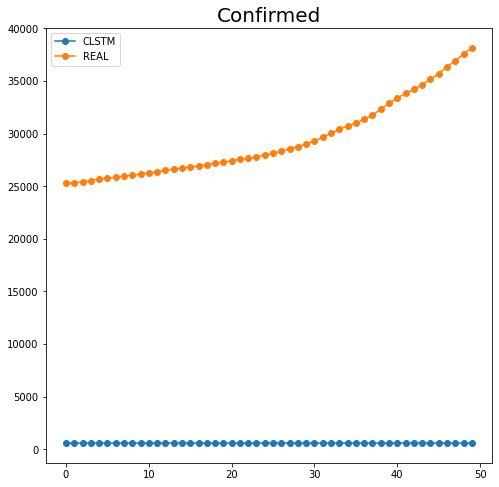

In [ ]:
# 확진자 예측 그래프
import matplotlib.pyplot as plt

pre = clstm_pre
real = test.reset_index(drop = True)

fig = plt.figure(figsize=(8,8))  ## 캔버스 생성
fig.set_facecolor('white')       ## 캔버스 색상 설정
ax = fig.add_subplot()           ## 그림 뼈대(프레임) 생성

# 그래프 생성
ax.plot(pre, marker='o',label='CLSTM')

ax.plot(real, marker='o',label='REAL') 

ax.legend() ## 범례
 
plt.title('Confirmed',fontsize=20) ## 타이틀 설정
plt.show()